In [13]:
import tifffile as tiff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, glob, math, cv2
import SimpleITK as sitk
import tensorflow as tf
from tensorflow.keras import Input, Model, layers
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import binary_crossentropy, hinge, squared_hinge

In [2]:
GPU = '-1'
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU)
gpus = tf.config.experimental.list_physical_devices('GPU')
[tf.config.experimental.set_memory_growth(gpu, True) for gpu in gpus]
tf.__version__

'2.3.1'

In [11]:
IMG_SIZE = 256
INITIAL_FILTERS = 32
LEARNING_RATE = 1e-3
OPTIMISER = Adam(LEARNING_RATE)
ACTIVATION = 'relu'
MODEL = 'models/lesion_0.5243661540846427.h5'

In [4]:
def load_tiffs(paths):
    images = dict()
    for path in sorted(paths):
        image = tiff.imread(path)
        if image.ndim==5:
            image = np.transpose(image[0,0], (2,1,0))
        images[path.split('/')[1].split('.')[0]] = image
    return images
    
training_images = load_tiffs(glob.glob('train/*.tiff'))
training_ids = list(training_images.keys())
#test_images = load_tiffs(glob.glob('test/*.tiff'))
#test_ids = list(test_images.keys())
print(training_ids)

['0486052bb', '095bf7a1f', '1e2425f28', '2f6ecfcdf', '54f2eec69', 'aaa6a05cc', 'cb2d976f4', 'e79de561c']


In [5]:
def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts+lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape((shape[::-1])).T[:,:,np.newaxis]

df_train = pd.read_csv(os.path.join("train.csv"))
training_masks = {ID:rle2mask(df_train[df_train["id"]==ID]["encoding"].values[0], training_images[ID].shape[:2]) for ID in training_ids}

In [28]:
#fig, ax = plt.subplots(1,2, figsize=(15,6))
#ax[0].imshow(training_images[0])

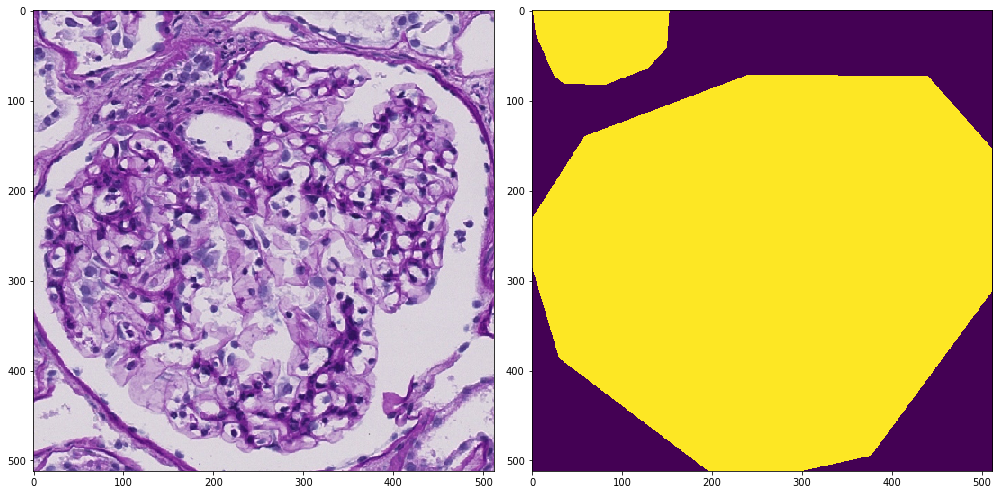

In [29]:
fig, ax = plt.subplots(1,2, figsize=(14,7))
x,y = 18150, 8050
size = 512
ax[0].imshow(training_images[training_ids[0]][x:x+size,y:y+size])
ax[1].imshow(training_masks[training_ids[0]][:,:,0][x:x+size,y:y+size])
plt.tight_layout()

In [6]:
for ID in training_ids:
    print(training_images[ID].shape, training_masks[ID].shape)

(25784, 34937, 3) (25784, 34937, 1)
(39000, 38160, 3) (39000, 38160, 1)
(32220, 26780, 3) (32220, 26780, 1)
(31278, 25794, 3) (31278, 25794, 1)
(22240, 30440, 3) (22240, 30440, 1)
(18484, 13013, 3) (18484, 13013, 1)
(34940, 49548, 3) (34940, 49548, 1)
(27020, 16180, 3) (27020, 16180, 1)


In [7]:
for ID in training_ids:
    dsize = training_images[ID].shape[1]//2, training_images[ID].shape[0]//2
    training_images[ID] = cv2.resize(training_images[ID], dsize=dsize)
    training_masks[ID] = cv2.resize(training_masks[ID][:,:,0], dsize=dsize)[:,:,np.newaxis]

In [8]:
for ID in training_ids:
    print(training_images[ID].shape, training_masks[ID].shape)

(12892, 17468, 3) (12892, 17468, 1)
(19500, 19080, 3) (19500, 19080, 1)
(16110, 13390, 3) (16110, 13390, 1)
(15639, 12897, 3) (15639, 12897, 1)
(11120, 15220, 3) (11120, 15220, 1)
(9242, 6506, 3) (9242, 6506, 1)
(17470, 24774, 3) (17470, 24774, 1)
(13510, 8090, 3) (13510, 8090, 1)


In [25]:
def enc2mask(encs, shape):
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for m,enc in enumerate(encs):
        if isinstance(enc,np.float) and np.isnan(enc): continue
        s = enc.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1 + m
    return img.reshape(shape).T

def mask2enc(mask, shape, n=1):
    pixels = mask.T.flatten()
    encs = []
    for i in range(1,n+1):
        p = (pixels == i).astype(np.int8)
        if p.sum() == 0: encs.append(np.nan)
        else:
            p = np.concatenate([[0], p, [0]])
            runs = np.where(p[1:] != p[:-1])[0] + 1
            runs[1::2] -= runs[::2]
            encs.append(' '.join(str(x) for x in runs))
    return encs

df_masks = pd.read_csv('train_csv').set_index('id')
df_masks.head()

,encoding
id,
2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
0486052bb,101676003 6 101701785 8 101727568 9 101753351 ...
e79de561c,8273094 14 8289273 41 8305453 67 8321632 82 83...


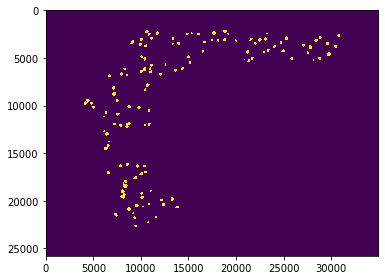

In [31]:
plt.imshow(training_masks[training_ids[0]][:,:,0])
plt.tight_layout()

In [6]:
# sizes = []
# for ID in training_ids:
#     components = sitk.GetArrayFromImage(sitk.ConnectedComponent(sitk.GetImageFromArray(training_masks[ID])))
#     print(f'{ID} Number of Components:', components.max())
#     for i in range(components.max()):
#         component = components==i+1
#         size = [array.max()-array.min() for array in np.where(component)]
#         sizes.append(size[:2])

In [9]:
def generate_patches_of_all(images, patch_size=IMG_SIZE):
    training_patches, validation_patches = [], []
    for n, ID in enumerate(images):
        image = images[ID]
        image_sizes = image.shape[:2]
        numbers_of_patches = [math.ceil(image_sizes[i]/patch_size) for i in range(2)]
        intervals = [(image_sizes[i]-patch_size)/(numbers_of_patches[i]-1) for i in range(2)]
        for i in range(numbers_of_patches[0]):
            for j in range(numbers_of_patches[1]):
                o = [round(i*intervals[0]), round(j*intervals[1])]
                if n in [6,7]:
                    validation_patches.append(image[o[0]:o[0]+patch_size, o[1]:o[1]+patch_size][np.newaxis])
                else:
                    training_patches.append(image[o[0]:o[0]+patch_size, o[1]:o[1]+patch_size][np.newaxis])
    return np.concatenate(training_patches, axis=0), np.concatenate(validation_patches, axis=0)

In [10]:
training_image_patches, validation_image_patches = generate_patches_of_all(training_images)
training_mask_patches, validation_mask_patches = generate_patches_of_all(training_masks)
print('training_image_patches.shape:', training_image_patches.shape)
print('training_mask_patches.shape:', training_mask_patches.shape)
print('validation_image_patches.shape:', validation_image_patches.shape)
print('validation_mask_patches.shape:', validation_mask_patches.shape)

training_image_patches.shape: (19397, 256, 256, 3)
training_mask_patches.shape: (19397, 256, 256, 1)
validation_image_patches.shape: (8389, 256, 256, 3)
validation_mask_patches.shape: (8389, 256, 256, 1)


In [11]:
voids = list()
for i in range(len(training_image_patches)):
    if not training_image_patches[i].any():
        voids.append(i)
training_image_patches = np.delete(training_image_patches, voids, 0)
training_mask_patches = np.delete(training_mask_patches, voids, 0)
print('training_image_patches.shape:', training_image_patches.shape)
print('training_mask_patches.shape:', training_mask_patches.shape)

training_image_patches.shape: (16535, 256, 256, 3)
training_mask_patches.shape: (16535, 256, 256, 1)


# Neural Network

In [15]:
def class_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + hinge(y_true, y_pred) + squared_hinge(y_true, y_pred)
    
def dice_coef(y_true, y_pred):
    smooth = 1e-6
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(y_pred, .5), tf.float32)
    return (2.*tf.reduce_sum(y_true*y_pred) + smooth)/(tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def class_dice_loss(y_true, y_pred):
    return class_loss(y_true, y_pred) + dice_loss(y_true, y_pred)

In [16]:
def np_dice(label, prediction):
    return (2.*(label&prediction).sum())/(label.sum()+prediction.sum())

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = load_model(MODEL, custom_objects={'bce_dice_loss':bce_dice_loss, 'dice_coef':dice_coef})

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [20]:
BATCHSIZE = 42*len(GPU.split(','))
prediction = model.predict(validation_image_patches, batch_size=BATCHSIZE)
prediction_masks = prediction>=.5
print(f'Dice Coefficient of the patch: {np_dice(validation_mask_patches, prediction_masks)}')

Dice Coefficient of the patch: 0.4626008448724751


In [29]:
def reverse_patch_shape(masks, labels, original_labels, patch_size=IMG_SIZE):
    predictions = []
    mask_index = 0
    for i, ID in enumerate(labels):
        if i not in [6,7]:
            continue
        label_sizes = labels[ID].shape[:2]
        numbers_of_patches = [math.ceil(label_sizes[j]/patch_size) for j in range(2)]
        intervals = [(label_sizes[j]-patch_size)/(numbers_of_patches[j]-1) for j in range(2)]
        prediction = np.zeros_like(labels[ID]).astype(bool)
        for j in range(np.prod(numbers_of_patches)):
            patch_indexes = [j//numbers_of_patches[1], j%numbers_of_patches[1]]
            o = [round(patch_indexes[k]*intervals[k]) for k in range(2)]
            prediction[o[0]:o[0]+patch_size, o[1]:o[1]+patch_size] |= masks[mask_index+j]
        mask_index += np.prod(numbers_of_patches)
        predictions.append(prediction)
    return predictions

predictions = reverse_patch_shape(prediction_masks, training_masks)

In [36]:
training_masks[training_ids[6]].shape, predictions[0].shape

((17470, 24774, 1), (17470, 24774, 1))

In [35]:
for ID in training_masks:
    print(training_masks[ID].shape)

(12892, 17468, 1)
(19500, 19080, 1)
(16110, 13390, 1)
(15639, 12897, 1)
(11120, 15220, 1)
(9242, 6506, 1)
(17470, 24774, 1)
(13510, 8090, 1)
